In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score, precision_recall_curve
from sklearn.model_selection import train_test_split, KFold, cross_val_score

## Data Acquisition

In [1]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv

--2025-10-22 17:39:31--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80876 (79K) [text/plain]
Saving to: ‘course_lead_scoring.csv’

course_lead_scoring 100%[===================>]  78.98K  --.-KB/s    in 0.007s  

2025-10-22 17:39:32 (11.3 MB/s) - ‘course_lead_scoring.csv’ saved [80876/80876]



In [2]:
df = pd.read_csv('course_lead_scoring.csv')

## Data Preparation

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lead_source               1334 non-null   object 
 1   industry                  1328 non-null   object 
 2   number_of_courses_viewed  1462 non-null   int64  
 3   annual_income             1281 non-null   float64
 4   employment_status         1362 non-null   object 
 5   location                  1399 non-null   object 
 6   interaction_count         1462 non-null   int64  
 7   lead_score                1462 non-null   float64
 8   converted                 1462 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 102.9+ KB


In [4]:
num_cols = df.select_dtypes(include=['number']).columns.to_list()
cat_cols = df.select_dtypes(exclude=['number']).columns.to_list()
len(num_cols) + len(cat_cols) == len(df.columns)

True

In [5]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [6]:
df[num_cols] = df[num_cols].fillna(0)
df[cat_cols] = df[cat_cols].fillna('NA')

## Train/Test Split

In [7]:
df_full_train, X_test = train_test_split(df, test_size=0.2, random_state=1)
X_train, X_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

for d in (X_train, X_val, X_test):
    d.reset_index(drop=True, inplace=True)

y_train = X_train.pop('converted').values
y_val = X_val.pop('converted').values
y_test = X_test.pop('converted').values

## Question 1

In [8]:
num_cols.remove('converted')

In [9]:
scores = {}
for col in num_cols:
    scores[col] = roc_auc_score(y_train, X_train[col])

print(f"Answer to Q1 is: {max(scores, key=scores.get)}")

Answer to Q1 is: number_of_courses_viewed


## Question 2

In [10]:
def train_and_predict(X_train, X_val, y_train, y_val, features_list, solver='liblinear', C=1.0, max_iter=1000):
    dv = DictVectorizer(sparse=False)

    train_dict = X_train[features_list].to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)

    val_dict = X_val[features_list].to_dict(orient='records')
    X_val = dv.transform(val_dict)

    model = LogisticRegression(solver=solver, C=C, max_iter=max_iter)
    model.fit(X_train, y_train)

    y_pred = model.predict_proba(X_val)[:, 1]
    return model, y_pred

In [11]:
_, y_pred = train_and_predict(X_train, X_val, y_train, y_val, features_list=X_train.columns, solver='lbfgs', C=1.0, max_iter=10000)
auc = roc_auc_score(y_val, y_pred)
print(f"Answer to Q2 is: {round(auc, 3)}")

Answer to Q2 is: 0.92


## Question 3

In [12]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [13]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['ppv'] = df_scores.tp / (df_scores.tp + df_scores.fp) # precision
df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn) # recall

In [14]:
df_scores

,threshold,tp,fp,fn,tn,ppv,tpr
0,0.00,171,122,0,0,0.583618,1.000000
1,0.01,171,116,0,6,0.595819,1.000000
2,0.02,171,109,0,13,0.610714,1.000000
3,0.03,170,108,1,14,0.611511,0.994152
4,0.04,170,104,1,18,0.620438,0.994152
...,...,...,...,...,...,...,...
96,0.96,64,2,107,120,0.969697,0.374269
97,0.97,58,0,113,122,1.000000,0.339181
98,0.98,47,0,124,122,1.000000,0.274854
99,0.99,39,0,132,122,1.000000,0.228070


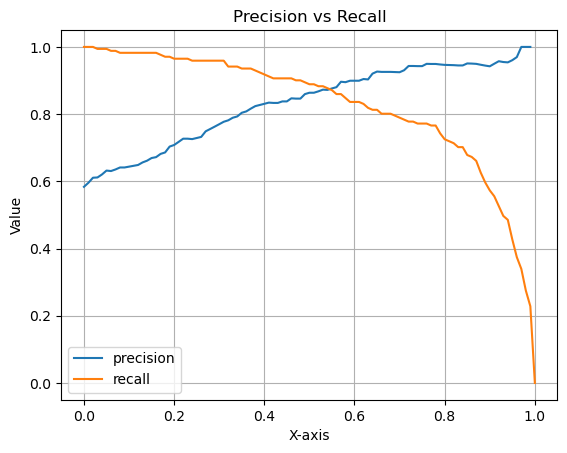

In [15]:
sns.lineplot(x='threshold', y='ppv', data=df_scores, label='precision')
sns.lineplot(x='threshold', y='tpr', data=df_scores, label='recall')

plt.title('Precision vs Recall')
plt.xlabel('X-axis')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
print(f"Answer to Q3 is: 0.545")

Answer to Q3 is: 0.545


## Question 4

In [17]:
df_scores['f1_score'] = 2 * (df_scores['ppv'] * df_scores['tpr']) / (df_scores['ppv'] + df_scores['tpr'])

In [18]:
max_f1_score_threshold = float(df_scores[df_scores['f1_score'] == df_scores['f1_score'].max()].threshold.iloc[0])

In [19]:
print(f"Answer to Q4 is: {max_f1_score_threshold}")

Answer to Q4 is: 0.53


## Question 5

In [52]:
X = df_full_train.drop('converted', axis=1)
y = df_full_train.converted

In [53]:
features_list = X.columns
dv = DictVectorizer(sparse=False)

train_dict = X[features_list].to_dict(orient='records')
X = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X, y)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [54]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)
scores = cross_val_score(model, X, y, cv=kf, scoring='roc_auc')
print(f"Answer to Q5 is: {round(np.std(scores), 2)}")

Answer to Q5 is: 0.04


## Question 6

In [57]:
C_values = [0.000001, 0.001, 1]

results = {
    C: (
        round(
            np.mean(
                scores := cross_val_score(
                    LogisticRegression(solver='liblinear', C=C, max_iter=1000),
                    X, y, cv=kf, 
                    scoring='roc_auc'
                )
            ), 3
        ),
        round(np.std(scores), 3)
    )
    for C in C_values
}

best_C = min(results, key=lambda C: (-results[C][0], results[C][1], C))
print(f"Answer to Q6 is: {best_C}")


Answer to Q6 is: 0.001
